Trying to analyze the double descent of fitted models

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import traceback
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from simple_data import *
from sklearn import metrics
from tqdm import tqdm
import seaborn as sns
import pickle as pkl
from copy import deepcopy
from os.path import join as oj
import viz
from numcompress import compress, decompress

In [2]:
out_dir = '/scratch/users/vision/chandan/double_descent/linear'

In [72]:
# ns - number of data points
# ps - number of features
# num_reps - how many repetitions
# noise_mults - how much to multiply noise vector by
# num_test - how many points in test distr.
def get_scores(model_type='linear', ns=None, ps=None, num_reps=50, noise_mults=[0.01, 0.1, 0.2], num_test=1000):
    if ns is None:
        ns = [100]
    if ps is None:
        ps = np.concatenate((np.arange(5, 500, 3), [750], [1000], [1500]))
    results_all = {}
    for n in ns:
        for noise_mult in noise_mults:

            results = {}
            train_scores = []
            test_scores = []
            wnorms = []
            pseudo_traces = []
            cov_traces = []
            nuclear_norms = []
            H_traces = []
            models_lists = []
            bias_list = []
            var_list = []
            mse_list = []
            for p in tqdm(ps):
                test_X, test_y = get_data(num_test, p, noise_mult=noise_mult, seed=703858704)
                ytrue = test_X[:, 0] # get true without any noise
                
                train_mse, test_mse, wnorm, pseudo_trace, cov_trace, nuclear_norm, H_trace = [], [], [], [], [], [], []
                num_succeeded_reps = 0
                models_list = []
                preds_list = []
                for reps in range(num_reps):    
                    try:
                        train_X, train_y = get_data(n, p, noise_mult=noise_mult, seed=reps)
#                         train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=reps, test_size=0.5)
                        # model = LinearRegression()
                        # model.fit(train_X, train_y)
                        
                        cov = train_X.T @ train_X
                        if p >= n:
                            inv = np.linalg.pinv(cov)
                        else:
                            inv = np.linalg.inv(cov)
                        w = inv @ train_X.T @ train_y

                        train_pred = train_X @ w
                        train_mse.append(metrics.mean_squared_error(train_pred, train_y))
                        test_pred = test_X @ w
                        test_mse.append(metrics.mean_squared_error(test_pred, test_y))
                        wnorm.append(np.linalg.norm(w))
                        
                        H = train_X @ inv @ train_X.T
                        # pseudo_trace += np.trace(inv)
                        # cov_trace += np.trace(cov)
                        # nuclear_norm += np.linalg.norm(inv, ord='nuc')
                        H_trace.append(np.trace(H))
                        num_succeeded_reps += 1
                        models_list.append(w)
                        preds_list.append(np.array(test_pred))
                    except:
#                         exc_type, exc_value, exc_traceback = sys.exc_info()
#                         print(traceback.print_tb(exc_traceback, limit=10, file=sys.stdout))
                        pass
                if num_succeeded_reps == 0:
                    train_mse, test_mse, wnorm, pseudo_trace, cov_trace, nuclear_norm, H_trace = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

                train_scores.append(np.array(train_mse))
                test_scores.append(np.array(test_mse))
                wnorms.append(np.array(wnorm))
                # pseudo_traces.append(pseudo_trace )
                # cov_traces.append(cov_trace)
                # nuclear_norms.append(nuclear_norm)
                H_traces.append(np.array(H_trace))
                models_lists.append(np.array(w))
                
                # calculate bias/var

                preds_list = np.array(preds_list) # num_reps x num_test
                preds_mu = np.mean(preds_list, axis=0) # num_test
                bias = np.mean(preds_mu - ytrue)
                var = np.mean(np.square(preds_list - preds_mu))
                mse = np.mean(np.square(preds_list - ytrue))
                bias_list.append(bias)
                var_list.append(var)
                mse_list.append(mse)
#                 print('bias', bias, 'var', var, 'mse', mse)
                
                

            train_scores = np.array(train_scores)
            test_scores = np.array(test_scores)
            results = {'ps': np.array(ps), 'ns': np.array(ns), 
                       'train_scores': np.array(train_scores), 'test_scores': np.array(test_scores), 
                       'wnorms': np.array(wnorms), # 'pseudo_traces': np.array(pseudo_traces), 
                       'H_traces': np.array(H_traces),
                       # 'cov_traces': np.array(cov_traces), 'nuclear_norms': np.array(nuclear_norms), 
                       'models_lists': models_lists, 
                       'bias_list': bias_list, 'var_list': var_list, 'mse_list': mse_list}
            results_all[noise_mult] = results
    return results_all

In [73]:
# ns_orig = [250]
# ps = np.concatenate((np.arange(25, 200, 5), np.arange(200, 300, 1), np.arange(300, 600, 20))) #, ))
noise_mults = [0.1] # 0.1, 0.001] #[0.01, 0.1, 0.2]
ns_orig = [750]
ps = np.concatenate((np.arange(50, 700, 50), np.arange(700, 750, 5), np.arange(750, 1000, 50))) #, ))
num_reps = 50
results_all = get_scores(model_type='linear', ns=ns_orig, noise_mults=[0.1], num_reps=num_reps, ps=ps)
# pkl.dump(results_all, open(oj(out_dir, './double_descent_min_norm_750.pkl'), 'wb'))

100%|██████████| 28/28 [04:59<00:00, 31.40s/it]


# load results

In [3]:
results_all = pkl.load(open(oj(out_dir, "double_descent_min_norm_750.pkl"), "rb" ) )
'''
double_descent_dense.pkl:
ns_orig = [250]
ps = np.concatenate((np.arange(25, 200, 1), np.arange(200, 500, 1), np.arange(500, 1000, 25)))
noise_mults = [0.1] #[0.01, 0.1, 0.2]
num_reps = 25

these were using the non-min norm estimator
'''


'''
double_descent_min_norm.pkl
ns_orig = [250]
ps = np.concatenate((np.arange(25, 200, 5), np.arange(200, 300, 1), np.arange(300, 600, 20))) #, ))
noise_mults = [0.1] # 0.1, 0.001] #[0.01, 0.1, 0.2]
num_reps = 50

these use min-norm estimator
'''

'''
double_descent_min_norm_750.pkl
noise_mults = [0.1] # 0.1, 0.001] #[0.01, 0.1, 0.2]
ns_orig = [750]
ps = np.concatenate((np.arange(50, 700, 50), np.arange(700, 750, 5), np.arange(750, 1000, 50))) #, ))
num_reps = 50

min-norm estimator
'''

'\ndouble_descent_min_norm_750.pkl\nnoise_mults = [0.1] # 0.1, 0.001] #[0.01, 0.1, 0.2]\nns_orig = [750]\nps = np.concatenate((np.arange(50, 700, 50), np.arange(700, 750, 5), np.arange(750, 1000, 50))) #, ))\nnum_reps = 50\n\nmin-norm estimator\n'

dict_keys([0.1])
num nan 0
num nan 0
num nan 0


/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


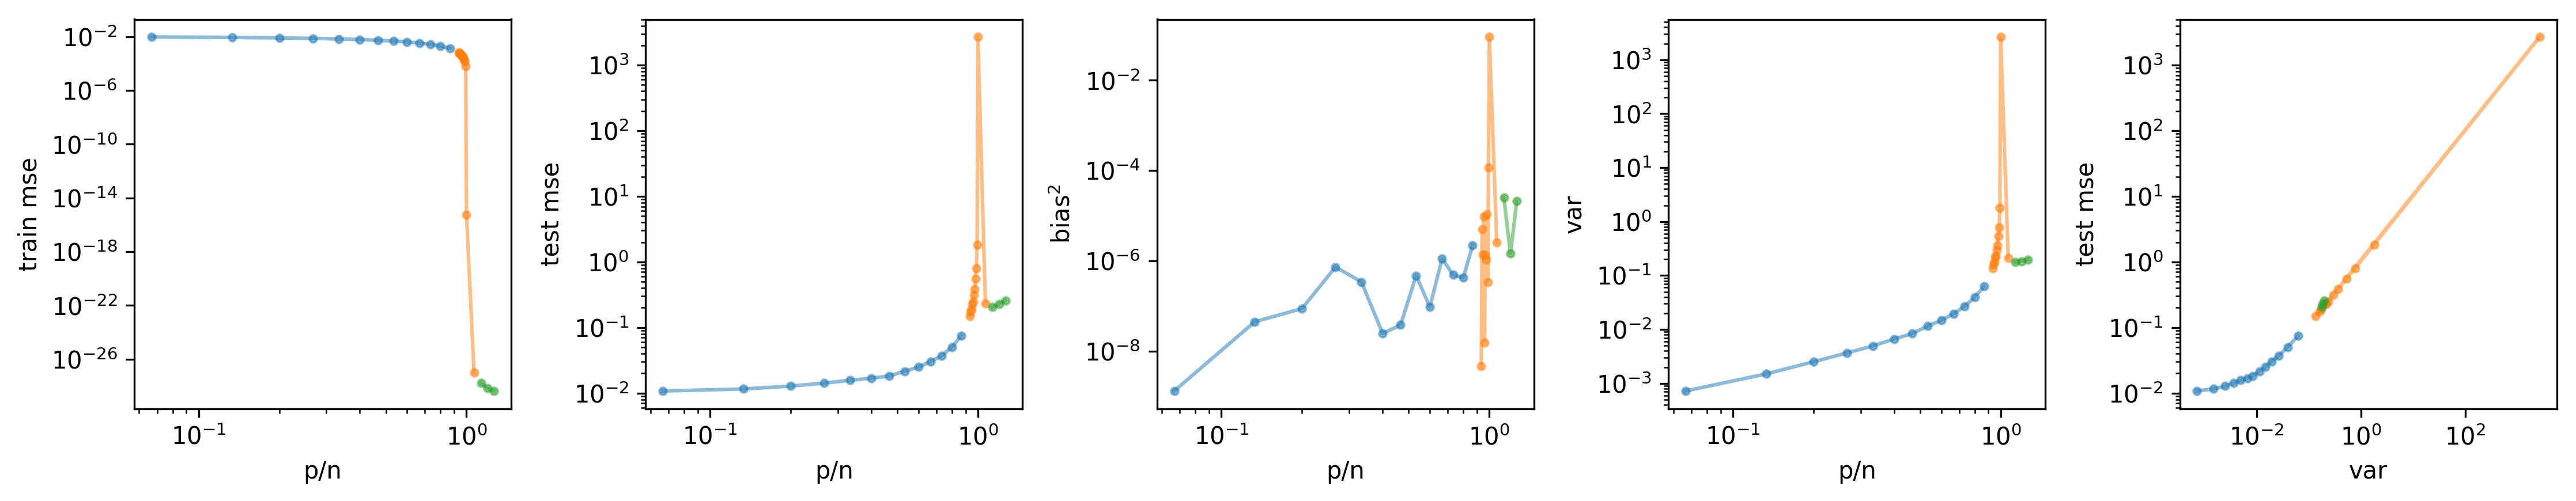

In [4]:
viz.plot_Htrace(results_all, [0.1]) #noise_mults)

In [5]:
orig = list(results_all[0.1]['models_lists'][0]) #.keys()

In [19]:
orig = list(range(1000))

In [20]:
# orig = results_all[0.1]['models_lists'][0] #.keys()
x = compress(orig)

In [ ]:
x

In [22]:
print(f'orig: {sys.getsizeof(orig)}, compressed: {sys.getsizeof(x)}')

orig: 9112, compressed: 3048


In [11]:
sys.getsizeof(decompress(x))

528